In [ ]:
import numpy as np           #importing libraries.
import math as m
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
def cross_entropy(Y, pred_y):          # defining cross entropy cost function. Y and pred_y are actual
    r, c = np.shape(pred_y)                     # and predicted labels of a specified dataset.
    error = 0
    index = np.argmax(Y, axis = 1)
    for i in range(r):
        error += -np.log(pred_y[i][index[i]])
    error = error/r
    return error                                 # returning cost value.


def sigmoid(z, diff):                 # defining sigmoid function. Where diff represents that this function used for differentiation or not.
    val = val = 1/(1 + np.exp(-z))
    if(diff == True):
        val = val*(1 - val)
    return val

def softmax(z, diff):         # defining softmax function.
    r, c = np.shape(z)
    val = np.exp(z)
    for i in range(c):
        denomenator = np.sum(val[:,i])
        val[:,i] = val[:,i]/denomenator
    return val

def Relu(z, diff):            # defining relu function.
    val = np.maximum(0, z)
    if(diff == True):
        for i in range(val.shape[0]):
            for j in range(val.shape[1]):
                if(z[i][j] > 0):
                    val[i][j] = 1
                else:
                    val[i][j] = 0
    return val



def grad_J(y, pred_y, pre_activation, activation_function):   # defining grad_J function to compute gradient of cost function
    r, c = np.shape(pred_y)                                     # with respect to optput layer's output.
    grad = np.zeros((r, c))

    one_hot_vector = np.zeros((r, c))
    for j in range(c):
        for i in range(r):
            if(y[i][j] == 1):
                one_hot_vector[i][j] = 1
    grad = -(one_hot_vector - pred_y)

    return grad                                            # returning gradient.



def forward_prop(x, n_layer, f_list, w_list, b_list):   # defining forward propagation algorithm to compute each layer's output.
    layer_output_list = []
    activation_list = []

    h = x
    for i in range(n_layer - 1):
        active = np.dot(w_list[i], h) + b_list[i]
        activation_list.append(active)
        output = f_list[i](active, diff = False)
        layer_output_list.append(output)
        h = output

    active = np.dot(w_list[n_layer - 1], h) + b_list[n_layer - 1]
    activation_list.append(active)
    output = f_list[n_layer - 1](active, diff = False)
    layer_output_list.append(output)

    return activation_list, layer_output_list    # returning each layer's pre-activation and output vector.



def Back_prop(x, y, n_layer, f_list, w_list, b_list, activation_list, layer_output_list):  # defining back propagation algorithm to calculate gradient
    r, c = np.shape(x)                              # of cost function with respect to each layer's weight and bias vector.
    grad_b_list = []
    grad_w_list = []

    g = grad_J(y, layer_output_list[n_layer - 1], activation_list[n_layer-1], f_list[n_layer-1])

    for k in range((n_layer-1), -1, -1):
        grad_b = np.sum(g, axis = 1, keepdims = True)/c
        grad_b_list.append(grad_b)

        if(k >= 1):
            grad_w = np.dot(g, layer_output_list[k-1].T)/c
            grad_w_list.append(grad_w)
        else:
            grad_w = np.dot(g, x.T)/c
            grad_w_list.append(grad_w)
            break

        g = np.dot(w_list[k].T , g)
        g = g*(f_list[k-1](activation_list[k-1], diff = True))

    grad_b_list = grad_b_list[ : : -1]
    grad_w_list = grad_w_list[ : : -1]

    return  grad_b_list,  grad_w_list   # returning gradients of cost function with respect to each layer's wight and bias vectors.


def calculate_error(X, Y, n_layer, f_list, w_list, b_list):     # This function calculates the error on the entire precified dataset.
    a, b = forward_prop(X.T, n_layer, f_list, w_list, b_list)
    y_pred = b[n_layer - 1].T
    error = cross_entropy(Y, y_pred)
    return error


def prediction(X, n_layer, f_list, w_list, b_list):        # This function computes the probability of being in each class.
    a, b = forward_prop(X.T, n_layer, f_list, w_list, b_list)
    y_pred = b[n_layer - 1].T
    return y_pred


def find_label(y):           # This function finds the predicted labels depending on above prediction.
    r, c = np.shape(y)
    labeled_y = np.zeros((r, c))
    for i in range(r):
        temp_max = np.max(y[i])
        for j in range(c):
            if(y[i][j] == temp_max):
                labeled_y[i][j] = 1
    return labeled_y


def accu(y, labeled_y):     # This function calculates the accuracy between actual and predicted labels.
    count = 0
    for i in range(y.shape[0]):
        if((y[i] == labeled_y[i]).all()):
            count += 1

    accuracy = count/y.shape[0]
    return accuracy



def Gradient_descent(X, Y, n_layer, f_list, w_list, b_list, learning_rate, nEpoch):  # This function optimizes the weight and bias vectors.
    row, col = np.shape(X)
    training_error = []


    for epoch in range(nEpoch):
        if(epoch % 10 == 0):
            err = calculate_error(X, Y, n_layer, f_list, w_list, b_list)
            y_train_pred = prediction(X, n_layer, f_list, w_list, b_list)
            labeled_y_train = find_label(y_train_pred)
            accurate = accu(Y, labeled_y_train)
            print(f'At {epoch} -th iteration, training error: {err}, accuracy: {accurate}')
            training_error.append(err)

        grad_b_list = []
        grad_w_list = []

        for i in range(n_layer):
            mat1 = np.zeros_like(w_list[i], dtype = float)
            grad_w_list.append(mat1)

            mat2 = np.zeros_like(b_list[i], dtype = float)
            grad_b_list.append(mat2)


        a, b = forward_prop(X.T, n_layer, f_list, w_list, b_list)     # calling forward propagation.
        c, d = Back_prop(X.T, Y.T, n_layer, f_list, w_list, b_list, a, b)    # calling backward propagation.

        for k in range(n_layer):
            grad_b_list[k] = c[k]
            grad_w_list[k] = d[k]

        for n in range(n_layer):
            b_list[n] -= learning_rate*grad_b_list[n]
            w_list[n] -= learning_rate*grad_w_list[n]

    return training_error, w_list, b_list   # returning training error , optimize weight and bias vectors of each layers'.


def parameter_initialization(x, layer_sizes):   # This function initialize the each layers' weight and bias vectors.
    length = len(x)
    w_list1 = [np.random.randn(layer_sizes[0], length)/np.sqrt(length)]
    w_list2 = [np.random.randn(next_layer, prev_layer)/np.sqrt(prev_layer) for prev_layer, next_layer in zip(layer_sizes[:-1], layer_sizes[1:])]
    w_list = w_list1 + w_list2

    b_list = [np.random.randn(layer, 1) for layer in layer_sizes]
    return w_list, b_list



In [ ]:
data = tf.keras.datasets.mnist.load_data() # extracting data from keras library.
type(data)

tuple

In [ ]:
(X_train, y_train), (X_test, y_test) = data   # dividing the entire dataset into train and test dataset.
X_train[0].shape
X_train.shape

y_train.shape
print('First five training y labels:')
print(y_train[:5])


First five training y labels:
[5 0 4 1 9]


In [ ]:
X_train = X_train.reshape((X_train.shape[0], 28*28)).astype('float32') # flatten the 2d picture to one dimenional vector.
X_test = X_test.reshape((X_test.shape[0], 28*28)).astype('float32')

X_train = X_train/255      # scalling the flattening vector to overcome the overflow.
X_test = X_test/255

print('The training set looks like:')
print(X_train)
r, c = np.shape(X_train)
print('The shape of training set is:')
print(r, c)

r1, c1 = np.shape(X_test)
print('The shape of testing set is:')
print(r1, c1)


The training set looks like:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The shape of training set is:
60000 784
The shape of testing set is:
10000 784


In [ ]:
# label vector i.e. y contains 10 categorical values. Therefore, we have to do one hot encoding of y vector.

y_train = pd.get_dummies(y_train, dtype = int)
y_train = y_train.values
print('The traing label is:')
print(y_train)
r2, c2 = np.shape(y_train)
print('The shape of training label is:')
print(r2, c2)

y_test = pd.get_dummies(y_test, dtype = int)
y_test = y_test.values
print('The test label is:')
print(y_test)
r3, c3 = np.shape(y_test)
print('The shape of test label is:')
print(r3, c3)


The traing label is:
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
The shape of training label is:
60000 10
The test label is:
[[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
The shape of test label is:
10000 10


# The number of layers in the neural network is 2. The first layer i.e. hidden  layer contains ReLU activation function of size 10. And the second layer i.e. output layer contains softmax function of size 10.

In [ ]:
n_layer = 2
layer_sizes = [10, 10]
w_list, b_list = parameter_initialization(X_train[0], layer_sizes)

f_list = [Relu, softmax]

#calling the Gradient Descent algorithm to compute optimal weight vectors.
err, list_w, list_b = Gradient_descent(X_train, y_train, n_layer, f_list, w_list, b_list, learning_rate = 0.1, nEpoch = 500)



At 0 -th iteration, training error: 3.3973057096555093, accuracy: 0.0993
At 10 -th iteration, training error: 2.33108966900554, accuracy: 0.22676666666666667
At 20 -th iteration, training error: 1.957508703777053, accuracy: 0.3405666666666667
At 30 -th iteration, training error: 1.7397479769495445, accuracy: 0.40603333333333336
At 40 -th iteration, training error: 1.581039549418456, accuracy: 0.47428333333333333
At 50 -th iteration, training error: 1.4416876379895756, accuracy: 0.5366
At 60 -th iteration, training error: 1.3092940503349428, accuracy: 0.5925333333333334
At 70 -th iteration, training error: 1.191917627657881, accuracy: 0.6366333333333334
At 80 -th iteration, training error: 1.0972040336030848, accuracy: 0.6736166666666666
At 90 -th iteration, training error: 1.0200750740703812, accuracy: 0.7002166666666667
At 100 -th iteration, training error: 0.956676564627257, accuracy: 0.72065
At 110 -th iteration, training error: 0.9039973782766992, accuracy: 0.7371
At 120 -th iterat

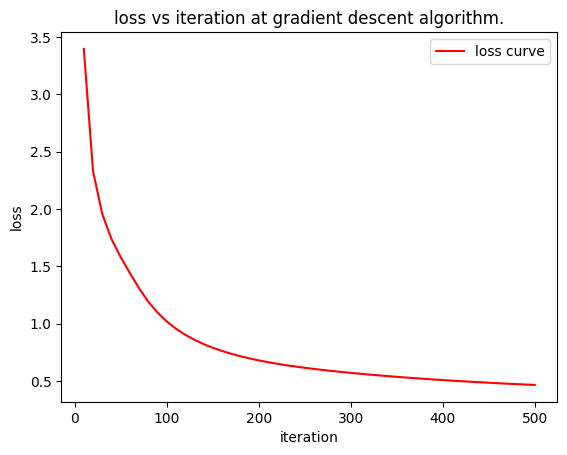

In [ ]:
n_iteration1 = len(err)  # array of costs .
n_iteration1 = list(i*10 for i in range(1, n_iteration1+1))

plt.plot(n_iteration1, err, color = 'red', label = 'loss curve')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss vs iteration at gradient descent algorithm.')
plt.legend(loc = 'upper right')
plt.show()


In [ ]:
# predicting probabilities of being in different classes  with the optimal weight vectors.
# This is for training dataset.
y_train_pred = prediction(X_train, n_layer, f_list, list_w, list_b)   # calling prediction function to compute prediction on training dataset.
print(f'The sum of the probabilities of being in different classes of a data sample is: {np.sum(y_train_pred[0])}')
print('The prediction of probabilities of being in different classes of each data sample is:')
print(y_train_pred)

The sum of the probabilities of being in different classes of a data sample is: 1.0000000000000002
The prediction of probabilities of being in different classes of each data sample is:
[[9.40596184e-02 7.75657275e-04 2.27260758e-02 ... 4.92881921e-03
  1.67940176e-01 1.53348229e-02]
 [9.97372980e-01 1.09757281e-07 5.17884451e-05 ... 3.87923998e-06
  7.46765394e-06 2.56920945e-05]
 [6.72425644e-03 2.30685632e-04 1.76257269e-02 ... 1.59938854e-03
  1.10421892e-02 3.07041028e-01]
 ...
 [1.72113660e-03 1.83489342e-05 1.01209541e-06 ... 2.91954547e-04
  9.96419471e-02 2.98160068e-02]
 [4.83635437e-02 3.78618477e-04 4.60281950e-02 ... 3.32328003e-04
  7.09174373e-03 5.93843609e-02]
 [3.28765605e-02 4.80377645e-03 2.37923438e-02 ... 1.13478218e-02
  3.17505342e-01 1.03423207e-01]]


In [ ]:
# finding label based on predicted value.

labeled_y_train = find_label(y_train_pred)    # calling find_label function to find corresponding label.
print(f'The predicted label for training dataset is:')
print(labeled_y_train)

The predicted label for training dataset is:
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
#printing the actual label of training dataset.

print('The actual label of training dataset:')
print(y_train)

The actual label of training dataset:
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [ ]:
accurate1 = accu(y_train, labeled_y_train)   # calling accuracy function to compute accuracy
print(f'The training accuracy is: {accurate1}')      # predicted label and actual lebel.


The training accuracy is: 0.8689


In [ ]:
# predicting probabilities of being in different classes  with the optimal weight vectors.
# This is for testing dataset.

y_pred = prediction(X_test, n_layer, f_list, list_w, list_b)  # calling prediction function to compute prediction on testing dataset.
print(f'The sum of the probabilities of being in different classes of a data sample is: {np.sum(y_pred[0])}')
print('The prediction of probabilities of being in different classes of each data sample is:')
print(y_pred)


The sum of the probabilities of being in different classes of a data sample is: 0.9999999999999999
The prediction of probabilities of being in different classes of each data sample is:
[[4.29081271e-04 1.78012832e-06 4.86078218e-05 ... 9.73059546e-01
  1.84421675e-05 2.50369055e-02]
 [1.34470483e-03 1.08983946e-04 9.86507062e-01 ... 1.02668307e-07
  1.46807899e-03 3.35090273e-06]
 [3.36899229e-04 9.56489971e-01 2.41688768e-02 ... 3.85168799e-03
  8.59034940e-03 2.73461228e-04]
 ...
 [2.41303540e-06 4.89103470e-07 8.26143725e-07 ... 4.07015869e-04
  2.14992609e-02 1.18534322e-01]
 [1.51764132e-03 5.81723185e-03 6.27449638e-05 ... 3.12688046e-05
  2.59322718e-01 9.25373266e-04]
 [7.51135933e-05 1.56294520e-05 2.72170925e-02 ... 1.89430676e-07
  2.87980887e-03 5.69128119e-05]]


In [ ]:
# finding label based on predicted value.

labeled_y = find_label(y_pred)    # calling find_label function to find corresponding label.
print(f'The predicted label for training dataset is:')
print(labeled_y)


The predicted label for training dataset is:
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
#printing the actual label of testing dataset.

print('The actual label of testing dataset:')
print(y_test)


The actual label of testing dataset:
[[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
accurate = accu(y_test, labeled_y)           # calling accuracy function to compute accuracy
print(f'The testing accuracy is: {accurate}')      # predicted label and actual lebel.


The testing accuracy is: 0.8684


# The number of layers in the neural network is 3. The first and second layer i.e. hidden layers contain ReLU activation function of size 20 and 10 respectively. And the third layer i.e. output layer contains softmax function of size 10.

In [ ]:
n_layer = 3
layer_sizes = [20, 10, 10]
w_list, b_list = parameter_initialization(X_train[0], layer_sizes)

f_list = [Relu, Relu, softmax]

#calling the Gradient Descent algorithm to compute optimal weight vectors.
err, list_w, list_b = Gradient_descent(X_train, y_train, n_layer, f_list, w_list, b_list, learning_rate = 0.1, nEpoch = 1000)

At 0 -th iteration, training error: 2.9524093478865576, accuracy: 0.10363333333333333
At 10 -th iteration, training error: 2.3941993875020184, accuracy: 0.25361666666666666
At 20 -th iteration, training error: 1.9413323685925277, accuracy: 0.3891833333333333
At 30 -th iteration, training error: 1.5938820801418603, accuracy: 0.56025
At 40 -th iteration, training error: 1.3537449296907538, accuracy: 0.6186833333333334
At 50 -th iteration, training error: 1.163142414642725, accuracy: 0.6617
At 60 -th iteration, training error: 1.0148166218946282, accuracy: 0.6979833333333333
At 70 -th iteration, training error: 0.9013894920785067, accuracy: 0.7300833333333333
At 80 -th iteration, training error: 0.8153753310692803, accuracy: 0.75565
At 90 -th iteration, training error: 0.7486094713286935, accuracy: 0.77565
At 100 -th iteration, training error: 0.6962837897251575, accuracy: 0.7916
At 110 -th iteration, training error: 0.6548455838262129, accuracy: 0.8040333333333334
At 120 -th iteration, t

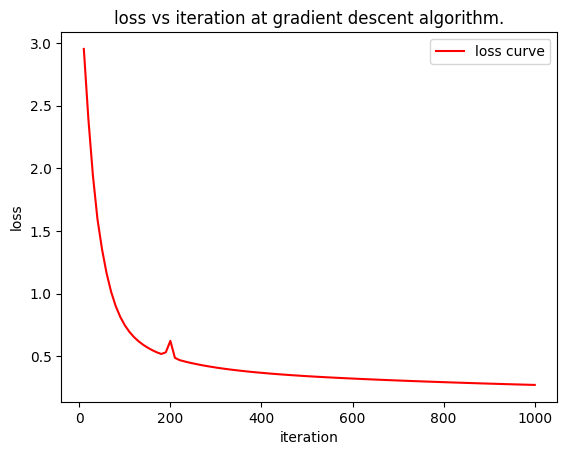

In [ ]:
n_iteration1 = len(err)  # array of costs .
n_iteration1 = list(i*10 for i in range(1, n_iteration1+1))

plt.plot(n_iteration1, err, color = 'red', label = 'loss curve')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss vs iteration at gradient descent algorithm.')
plt.legend(loc = 'upper right')
plt.show()


In [ ]:
# predicting probabilities of being in different classes  with the optimal weight vectors.
# This is for training dataset.
y_train_pred = prediction(X_train, n_layer, f_list, list_w, list_b)   # calling prediction function to compute prediction on training dataset.
print(f'The sum of the probabilities of being in different classes of a data sample is: {np.sum(y_train_pred[0])}')
print('The prediction of probabilities of being in different classes of each data sample is:')
print(y_train_pred)


The sum of the probabilities of being in different classes of a data sample is: 1.0000000000000002
The prediction of probabilities of being in different classes of each data sample is:
[[3.81325339e-03 6.29365113e-07 1.03452167e-03 ... 4.05507392e-04
  1.37744309e-03 1.16463444e-04]
 [9.99364707e-01 1.00254332e-12 2.50307724e-04 ... 1.35268444e-06
  7.13190995e-06 7.13035813e-06]
 [1.56361110e-04 9.15797130e-05 2.10528865e-03 ... 2.49660088e-02
  1.37276477e-03 6.52603501e-02]
 ...
 [5.15195800e-05 2.13383645e-06 3.05984248e-06 ... 2.18188198e-05
  2.85666043e-03 9.65828559e-04]
 [2.27187998e-02 5.33019961e-08 1.26234372e-02 ... 5.26712003e-04
  2.14902581e-04 3.05100858e-03]
 [1.07175516e-01 2.19465532e-05 1.22541772e-02 ... 1.77762330e-04
  8.36973006e-01 1.31209607e-02]]


In [ ]:
# finding label based on predicted value.

labeled_y_train = find_label(y_train_pred)    # calling find_label function to find corresponding label.
print(f'The predicted label for training dataset is:')
print(labeled_y_train)


The predicted label for training dataset is:
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
#printing the actual label of training dataset.

print('The actual label of training dataset:')
print(y_train)


The actual label of training dataset:
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [ ]:
accurate1 = accu(y_train, labeled_y_train)   # calling accuracy function to compute accuracy
print(f'The training accuracy is: {accurate1}')      # predicted label and actual lebel.


The training accuracy is: 0.9225


In [ ]:
# predicting probabilities of being in different classes  with the optimal weight vectors.
# This is for testing dataset.

y_pred = prediction(X_test, n_layer, f_list, list_w, list_b)  # calling prediction function to compute prediction on testing dataset.
print(f'The sum of the probabilities of being in different classes of a data sample is: {np.sum(y_pred[0])}')
print('The prediction of probabilities of being in different classes of each data sample is:')
print(y_pred)


The sum of the probabilities of being in different classes of a data sample is: 1.0
The prediction of probabilities of being in different classes of each data sample is:
[[4.75014425e-05 5.12637453e-07 2.16741287e-03 ... 9.95421177e-01
  3.26845911e-06 1.14217699e-03]
 [8.34031878e-04 2.15401834e-06 9.97212795e-01 ... 2.73667796e-08
  1.10451073e-04 2.29073448e-12]
 [4.99920533e-07 9.80861974e-01 4.83464599e-03 ... 3.07340986e-03
  4.46065250e-03 1.05570753e-04]
 ...
 [3.26821308e-08 2.18302410e-07 8.85743915e-06 ... 1.82410925e-04
  6.73748153e-04 2.48577113e-02]
 [7.52707695e-05 6.34605029e-05 4.79749097e-05 ... 4.05990523e-07
  4.19548635e-02 3.72331609e-05]
 [9.08278959e-06 3.47790113e-14 3.31376791e-04 ... 7.50951582e-10
  2.20292635e-08 2.11641883e-09]]


In [ ]:
# finding label based on predicted value.

labeled_y = find_label(y_pred)    # calling find_label function to find corresponding label.
print(f'The predicted label for training dataset is:')
print(labeled_y)


The predicted label for training dataset is:
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
#printing the actual label of testing dataset.

print('The actual label of testing dataset:')
print(y_test)


The actual label of testing dataset:
[[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
accurate = accu(y_test, labeled_y)           # calling accuracy function to compute accuracy
print(f'The testing accuracy is: {accurate}')      # predicted label and actual lebel.


The testing accuracy is: 0.9226


#Question :- How much improvement does the larger network provide?

#Answer :- The larger network provides around 4 - 5 % improvement.